## ECON 4003 Data Skills for Computational Social Science

### The Gender Wage Gap in the U.S.

Name: Sitong Guo



## Introduction

This project is inspired by ECON\-GA 1108 lectures.

In the course of social development and transformation, the differences between groups divided by gender have always existed. At the same time, on account of the effects of economy, politics and ideology, the size of the gender differences changes from time to time. In addition, studying gender inequality also has been instrumental in measuring the extent of inequality of the whole society.

This project consists of two parts centering on the gender wage gap. The gender wage gap has been studied for decades, but still remains an area of active research. As women's labor force participation rate increases, the gender wage gap has narrowed but not proportionally. Education, occupation and income, as the three main components of the social stratification system, are not only important indicators reflecting individuals' socioeconomic status, but also common dimensions used by many scholars to measure gender inequality \(Treiman, 1970\). Therefore, scholars started to examine the causes of gender wage inequality mainly from the perspectives of family responsibility, human capital and occupational segmentation. In recent years, social capital has also attracted much attention. In this project, I will explore if there is a contradiction between theory and reality by visualizing data related to earnings, educational attainment and occupation.
[]() <br>

## Outline

- [The gender wage gap](#1)
  - [Time trends](#2)
- [Possible causes of the gender wage gap](#3)
  - [Human capital](#3)
  - [Occupational segmentation](#4)



In [1]:
import requests
import json
import pandas as pd
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import altair as alt
from altair.expr import datum

/projects/33a62f75-6b32-4947-b8fc-b22428dc9ec6/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


<a id="1"></a>
## The Gender Wage Gap

- `WKEARNI`: This variable identifies a respondent's weekly earnings.
- `AGE`: This variable identifies a respondent's age.
- `SEX`: This variable identifies a respondent's gender.
- `FULLLF`: This variable identifies if a respondent is a employed full-time worker.
  - `1 -> Not in labor force`
  - `2 -> FT hours (35+), usually ft`
  - `3 -> PT for economic reasons, usually ft`
  - `4 -> PT for non-economic reasons, usually ft`
  - `5 -> Not at work-FT usually`
  - `6 -> PT/usl PT-economic reasons`
  - `7 -> PT/usl PT-non-economic`
  - `8 -> FT/usl PT-economic reasons`
  - `9 -> FT/usl PT-non-economic`
  - `10 -> Not at work-PT usually`
  - `11 -> Unemployment FT`
  - `12 -> Unemployment PT`
- `EDUC`: This variable identifies a respondent's educational attainment.
  - `0 -> Children`
  - `31 -> Less than 1st grade`
  - `32 -> 1st, 2nd, 3rd, or 4th grade`
  - `33 -> 5th or 6th grade`
  - `34 -> 7th and 8th grade`
  - `35 -> 9th grade`
  - `36 -> 10th grade`
  - `37 -> 11th grade`
  - `38 -> 12th grade No diploma`
  - `39 -> High school graduate-high school diploma`
  - `40 -> Some College But No degree`
  - `41 -> Assc degree-occupation/vocation`
  - `42 -> Assc degree-academic program`
  - `43 -> Bachelor's degree (BA,AB,BS)`
  - `44 -> Master's degree (MA,MS,MENG,MED,MSW,MBA)`
  - `45 -> Professional school degree (MD,DDS,DVM,L)`
  - `46 -> Doctorate degree (PhD,EdD)`
- `RACE`: This variable identifies a respondent's race.
  - `1 -> White only`
  - `2 -> Black only`
  - `3 -> American Indian, Alaskan Native only`
  - `4 -> Asian only`
  - `5 -> Hawaiian/Pacific Islander only`
  - `6 -> White-Black`
  - `7 -> White-AI`
  - `8 -> White-Asian`
  - `9 -> White-HP`
  - `10 -> Black-AI`
  - `11 -> Black-Asian`
  - `12 -> Black-HP`
  - `13 -> AI-Asian`
  - `14 -> AI-HP`
  - `15 -> Asian-HP`
  - `16 -> W-B-AI`
  - `17 -> W-B-A`
  - `18 -> W-B-HP`
  - `19 -> W-AI-A`
  - `20 -> W-AI-HP`
  - `21 -> W-A-HP`
  - `22 -> B-AI-A`
  - `23 -> W-B-AI-A`
  - `24 -> W-AI-A-HP`
  - `25 -> Other 3 race combinations`
  - `26 -> Other 4 and 5 race combinations`
- `SEX: This variable identifies a respondent's gender.`
  - `1 -> Male`
  - `2 -> Female`



In [2]:
def request_for_variables(
        year:str,
        variables: List[str],
        census_api_key: str,
    ):
    """
    Request data for all ``variables`` in ``year``
    
    Parameters
    ----------
    year: string
        The year from which requested data is
    
    variables: List[str]
        A list of all variable names for which to request data
    
    census_api_key: string
        An API key to enable more extensive use of the
        api and more detailed results
    
    Returns
    -------
    responses: List[requests.request]
        A list of `Response` objects from the requests library
    """
    url = "https://api.census.gov/data/{0}/cps/asec/mar?get={1}&key={2}".format(year, variables, census_api_key)
    response = requests.request("GET", url)
    if response.status_code > 299:
        raise ValueError(f"Response error with code {response.status_code}")
    else:
        return response

In [3]:
vardict = {
    "A_GRSWK": "WKEARNI",
    "A_HGA": "EDUC",
    "PRDTRACE": "RACE",
    "A_AGE": "AGE",
    "A_SEX": "SEX",
    "PRWKSTAT": "FULLLF"
}

In [4]:
def make_df(response):
    """
    Unpack a list of response objects into data objects
    
    Parameters
    ----------
    response: List[requests.request]
        A list of `Response` objects from the requests library
    
    Returns
    -------
    data: pd.DataFrame
        A pandas DataFrame containing responses from respondents
        who worked full-time and are 18-64 years old
    """
    r = response.json()
    df = pd.DataFrame(r[1:], columns=r[0]
                  ).rename(columns=vardict
                  ).astype(dtype="int64")
    df.drop(df[(df["WKEARNI"] == 0) | (df["FULLLF"] != 2) | (df["AGE"] < 18) | (df["AGE"] > 64)].index, inplace=True)
    df = df.reset_index(drop=True)
    df["byAGE"] = pd.cut(x=df["AGE"], bins=[17, 24, 34, 44, 54, 64]).astype("str")
    df.drop(["FULLLF", "AGE"], axis=1, inplace=True)
    return df

In [5]:
def get_census_data(
        year:str,
        variables: List[str],
        census_api_key: str,
    ):
    """
    Request data for all ``variables`` in ``year`` and unpack it
    into data objects
    
    Parameters
    ----------
    year: string
        The year from which requested data is
    
    variables: List[str]
        A list of all variable names for which to request data
    
    census_api_key: string
        An API key to enable more extensive use of the
        api and more detailed results
    
    Returns
    -------
    data: pd.DataFrame
        A pandas DataFrame containing responses from interviewees who worked
        full-time
    """
    response = request_for_variables(year, variables, census_api_key)
    df = make_df(response)
    return df

In [6]:
census_api_key = "27e5036885ad59f33175051ffedab703bd047fed" #secret
variables = "A_GRSWK,A_HGA,PRDTRACE,A_AGE,A_SEX,PRWKSTAT"
year = "2021"

In [7]:
df1 = get_census_data(year, variables, census_api_key)
df1.head()

,WKEARNI,EDUC,RACE,SEX,byAGE
0,481,43,1,1,"(24, 34]"
1,1709,39,1,1,"(24, 34]"
2,1056,43,1,2,"(44, 54]"
3,1080,43,1,1,"(34, 44]"
4,1152,43,1,2,"(34, 44]"


In [8]:
educdict = {
    31: "Less than 1st grade",
    32: "1st-4th grade",
    33: "5th-6st grade",
    34: "7th-8st grade",
    35: "9th grade",
    36: "10th grade",
    37: "11th grade",
    38: "12th grade no dipoloma",
    39: "High school",
    40: "Some college no degree",
    41: "Assc degree - occupation",
    42: "Assc degree - academic prog",
    43: "Bachelor's degree",
    44: "Master's degree",
    45: "Professional school degree",
    46: "Doctorate degree"
}

In [9]:
# Median weekly earnings of white female / white male
wo = df1[df1["RACE"] == 1].drop(["RACE"], axis=1)
wom = wo[wo["SEX"] == 1
        ].drop(["SEX"], axis=1
        ).reset_index(drop=True)
medwom = wom.pivot_table(index="EDUC", columns="byAGE", values="WKEARNI", aggfunc="median"
                        ).rename(index=educdict)
wof = wo[wo["SEX"] == 2
        ].drop(["SEX"], axis=1
        ).reset_index(drop=True)
medwof = wof.pivot_table(index="EDUC", columns="byAGE", values="WKEARNI", aggfunc="median"
                        ).rename(index=educdict)
wfwm = medwof / medwom
wfwm.to_csv("median_ratio_w.csv")

In [10]:
# Median weekly earnings of black female / black male
bo = df1[df1["RACE"] == 2].drop(["RACE"], axis=1)
bom = bo[bo["SEX"] == 1
        ].drop(["SEX"], axis=1
        ).reset_index(drop=True)
medbom = bom.pivot_table(index="EDUC", columns="byAGE", values="WKEARNI", aggfunc="median"
                        ).rename(index=educdict)
bof = bo[bo["SEX"] == 2
        ].drop(["SEX"], axis=1
        ).reset_index(drop=True)
medbof = bof.pivot_table(index="EDUC", columns="byAGE", values="WKEARNI", aggfunc="median"
                        ).rename(index=educdict)
bfbm = medbof / medbom
bfbm.to_csv("median_ratio_b.csv")
bfbm.tail()

byAGE,"(17, 24]","(24, 34]","(34, 44]","(44, 54]","(54, 64]"
EDUC,,,,,
High school,0.738413,0.996610,0.817057,0.793061,0.771850
Less than 1st grade,NaN,NaN,NaN,NaN,NaN
Master's degree,NaN,0.817443,0.606943,0.436460,1.009335
Professional school degree,NaN,0.755119,1.383710,0.366378,NaN
Some college no degree,0.931315,0.813559,0.895389,0.497321,0.692341


In [11]:
# Average median weekly earnings ratio
wfwm_mean = wfwm.mean()
wfwm_mean_all = wfwm_mean.mean()
print(wfwm_mean)
wfwm_mean_all

byAGE
(17, 24]    0.859702
(24, 34]    0.930183
(34, 44]    0.801998
(44, 54]    0.719940
(54, 64]    0.818355
dtype: float64


0.826035557809617

In [12]:
bfbm_mean = bfbm.mean()
bfbm_mean_all = bfbm_mean.mean()
print(bfbm_mean)
bfbm_mean_all

byAGE
(17, 24]    0.813924
(24, 34]    0.903281
(34, 44]    0.836847
(44, 54]    0.660061
(54, 64]    0.773889
dtype: float64


0.7976002491134846

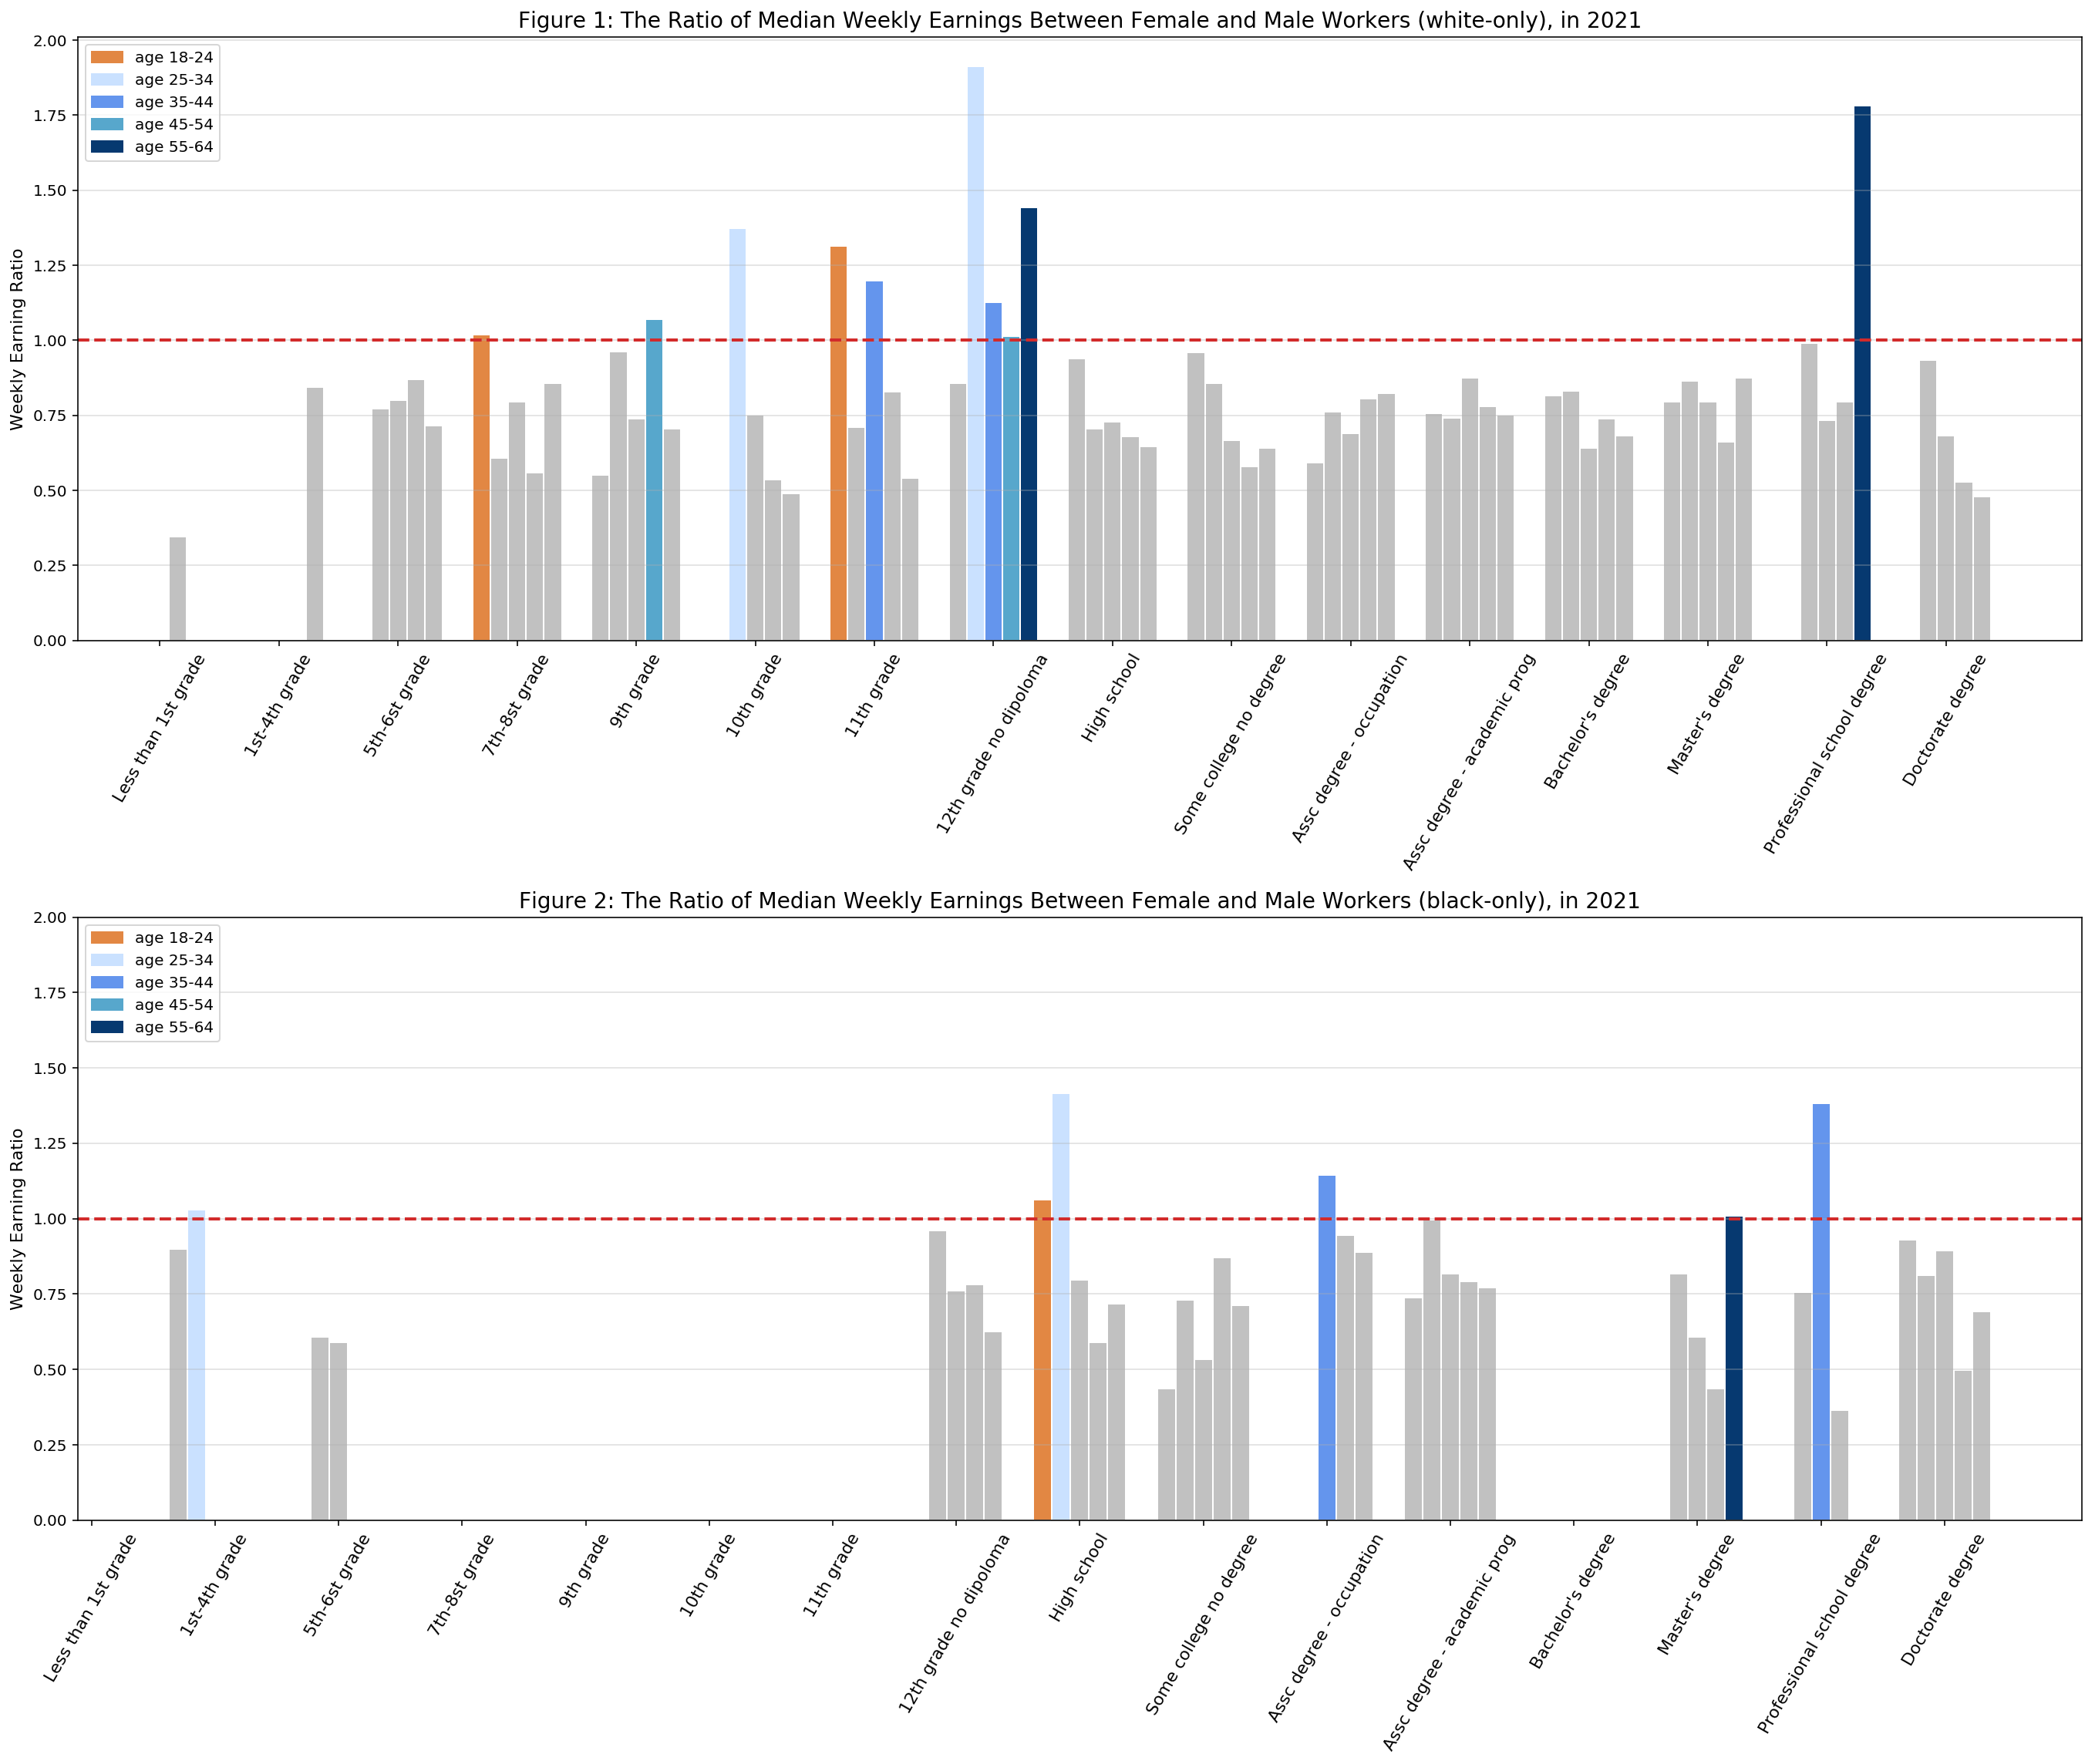

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(19, 16))
barWidth = 0.15
r1 = np.arange(len(wfwm))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

patch24 = mpatches.Patch(color="#e28743", label="age 18-24")
patch34 = mpatches.Patch(color="#CAE1FF", label="age 25-34")
patch44 = mpatches.Patch(color="#6495ED", label="age 35-44")
patch54 = mpatches.Patch(color="#57a7cc", label="age 45-54")
patch64 = mpatches.Patch(color="#063970", label="age 55-64")

color01 = ["#C1C1C1" if i < 1 else "#e28743" for i in wfwm["(17, 24]"]]
color02 = ["#C1C1C1" if i < 1 else "#CAE1FF" for i in wfwm["(24, 34]"]]
color03 = ["#C1C1C1" if i < 1 else "#6495ED" for i in wfwm["(34, 44]"]]
color04 = ["#C1C1C1" if i < 1 else "#57a7cc" for i in wfwm["(44, 54]"]]
color05 = ["#C1C1C1" if i < 1 else "#063970" for i in wfwm["(54, 64]"]]

color11 = ["#C1C1C1" if i < 1 else "#e28743" for i in bfbm["(17, 24]"]]
color12 = ["#C1C1C1" if i < 1 else "#CAE1FF" for i in bfbm["(24, 34]"]]
color13 = ["#C1C1C1" if i < 1 else "#6495ED" for i in bfbm["(34, 44]"]]
color14 = ["#C1C1C1" if i < 1 else "#57a7cc" for i in bfbm["(44, 54]"]]
color15 = ["#C1C1C1" if i < 1 else "#063970" for i in bfbm["(54, 64]"]]

rects01 = ax[0].bar(r1, wfwm["(17, 24]"], width=barWidth, color=color01, edgecolor="white")
rects02 = ax[0].bar(r2, wfwm["(24, 34]"], width=barWidth, color=color02, edgecolor="white")
rects03 = ax[0].bar(r3, wfwm["(34, 44]"], width=barWidth, color=color03, edgecolor="white")
rects04 = ax[0].bar(r4, wfwm["(44, 54]"], width=barWidth, color=color04, edgecolor="white")
rects05 = ax[0].bar(r5, wfwm["(54, 64]"], width=barWidth, color=color05, edgecolor="white")

rects11 = ax[1].bar(r1, bfbm["(17, 24]"], width=barWidth, color=color11, edgecolor="white")
rects12 = ax[1].bar(r2, bfbm["(24, 34]"], width=barWidth, color=color12, edgecolor="white")
rects13 = ax[1].bar(r3, bfbm["(34, 44]"], width=barWidth, color=color13, edgecolor="white")
rects14 = ax[1].bar(r4, bfbm["(44, 54]"], width=barWidth, color=color14, edgecolor="white")
rects15 = ax[1].bar(r5, bfbm["(54, 64]"], width=barWidth, color=color15, edgecolor="white")

for i in [0,1]:
    ax[i].grid(axis='y', alpha=0.4)
    ax[i].set_xticks([r + 2*barWidth for r in range(len(wfwm))])
    ax[i].set_xticklabels(wfwm.index, size=11)
    ax[i].tick_params(axis="x", labelrotation=60)
    ax[i].set_ylabel("Weekly Earning Ratio", size=11)
    ax[i].axhline(y=1, color="#D22B2B", linestyle='--', lw=2)
    ax[i].legend(handles=[patch24, patch34, patch44, patch54, patch64], loc="upper left")
ax[0].set_title("Figure 1: The Ratio of Median Weekly Earnings Between Female and Male Workers (white-only), in 2021", size=14)
ax[1].set_title("Figure 2: The Ratio of Median Weekly Earnings Between Female and Male Workers (black-only), in 2021", size=14)
ax[1].set_ylim(0, 2)

fig.tight_layout()

We first look at the wage gap between female and male workers. Figure 1 and 2 show the ratio in weekly earnings between female and male workers in 2021 by age and educational attainment. The data are only for employees who worked full-time (35 or more hours per week).

We can see that the wage gender gap widely exists in each age, race and educational attainment group.

- Among all white respondents who were full-time, full-year workers, women made, on average, only 83 percent the weekly earnings of male workers.
- Younger females did better than the olders.
  - The average earnings of white females aged 25 to 34 was up to 93 percent that of males, whereas middle-aged white females (aged 45 to 54) earned only about 72 percent of males in the same age group.
- The earnings ratio shows relatively little variation by educational attainment.
  - Among younger workers (under 35), the female–male earnings ratio was slightly greater among less educated (no high school diploma) workers than other educational groups.
  - Female workers aged 25 to 34 earned nearly twice as much as male workers in the same age group.
  - Female workers aged 55 to 64 earned much more than male workers in the same age group.


- Black females earned, on average, 20 percent less than black males.
- There is again very little systematic variation in the earnings ratio by educational attainment group.
  - The earnings ratios are exceptionally low among well-educated workers. Female workers aged 45 to 54 who went to professional school earned far less than half of what male workers earned in the same age group.

<a id="2"></a>
### Time Trends

1. Number and real median earnings of total workers and full-time, year-round workers (df2): [Income in the United States: 2021](https://www.census.gov/library/publications/2022/demo/p60-276.html)

    Earnings in 2021 dollars, adjusted using the R-CPI-U-RS. People 15 years and older as of March of the following year beginning in 1980, and people 14 years old and older as of March of the following year for previous years. Before 1989 earnings are for civilian workers only.

- `NUM_TM -> Number of total male workers (thousands)`
- `MEDEARNI_TM -> Median earnings for total male workers (dollars)`
- `MOE_TM -> Margin of error of the estimates of median earnings for total male workers (±)`
- `NUM_TF -> Number of total female workers (thousands)`
- `MEDEARNI_TF -> Median earnings for total female workers (dollars)`
- `MOE_TF -> Margin of error of the estimates of median earnings for total female workers (±)`
- `NUM_FTM -> Number of total full-time, year-round male workers (thousands)`
- `MEDEARNI_FTM -> Median earnings for total full-time, year-round male workers (dollars)`
- `MOE_FTM -> Margin of error of the estimates of median earnings for total full-time, year-round male workers (±)`
- `NUM_FTF -> Number of total full-time, year-round female workers (thousands)`
- `MEDEARNI_FTF -> Median earnings for total full-time, year-round female workers (dollars)`
- `MOE_FTF -> Margin of error of the estimates of median earnings for total full-time, year-round female workers (±)`
- `FTEARNI_F_M -> Female-to-male earnings ratio`

2. US business cycle expansions and contractions (bc):

    Contractions (recessions) start at the peak of a business cycle and end at the trough.

In [14]:
df2 = pd.read_csv("time_series_earnings.csv", index_col=0)
df2["Month"] = 3
df2["Date"] = pd.to_datetime(df2[["Year", "Month"]].assign(DAY=1))
df2.head()

,Year,NUM_TM,MEDEARNI_TM,MOE_TM,NUM_TF,MEDEARNI_TF,MOE_TF,NUM_FTM,MEDEARNI_FTM,MOE_FTM,NUM_FTF,MEDEARNI_FTF,MOE_FTF,FTEARNI_F_M,Month,Date
0,2021,88941.0,50983,222.0,79100.0,39201,753.0,66366.0,61180,294.0,50991.0,51226,295.0,0.837,3,2021-03-01
1,2020,88645.0,51446,973.0,79504.0,37527,319.0,60295.0,64217,296.0,46002.0,53387,290.0,0.831,3,2020-03-01
2,2019,89023.0,51684,871.0,80779.0,37967,281.0,67123.0,60890,917.0,52035.0,50126,389.0,0.823,3,2019-03-01
3,2018,88115.0,50432,439.0,79440.0,35232,745.0,67205.0,59657,512.0,50795.0,48658,525.0,0.816,3,2018-03-01
4,2017,88020.0,49811,745.0,78291.0,35244,211.0,66500.0,57679,247.0,49227.0,47105,964.0,0.817,3,2017-03-01


In [15]:
request = requests.get('http://data.nber.org/data/cycles/business_cycle_dates.json')
recession = request.json()
bc = pd.DataFrame(recession).apply(pd.to_datetime).query("trough > 1959").reset_index(drop=True)
bc.to_csv("business_cycle.csv")
bc.head()

,peak,trough
0,1960-04-01,1961-02-01
1,1969-12-01,1970-11-01
2,1973-11-01,1975-03-01
3,1980-01-01,1980-07-01
4,1981-07-01,1982-11-01


<div class="alert alert-block alert-success">
<b>Up to you:</b> The DejaVu Sans fonts are available for download at https://dejavu-fonts.github.io/ </div>

In [16]:
def altfont():
    font = "DejaVu Sans"
    
    return {
        "config" : {
             "title": {"font": font,
                       "fontWeight": 400,
                       "fontSize": 13},
             "axis": {"labelFont": font,
                      "titleFont": font,
                      "titleFontStyle": "light",
                      "titleFontSize": 11},
             "legend": {"labelFont": font,
                       "titleFont": font}
                    }
    }

alt.themes.register("dvsans", altfont)
alt.themes.enable("dvsans")

ThemeRegistry.enable('dvsans')

In [17]:
line = alt.Chart(df2).mark_area(color="#99CCFF", opacity=0.3, line=True
                               ).encode(alt.X("Date:T",
                                              axis=alt.Axis(title="", format="%Y", grid=False)),
                                        alt.Y("FTEARNI_F_M:Q",
                                              axis=alt.Axis(title="Annual Earning Ratio F/M"),
                                              scale=alt.Scale(domain=(0, 1)))
                               ).properties(title="Figure 3: The Ratio of Median Annual Earnings Between Female and Male Workers, 1960-2021")
rect = alt.Chart(bc).mark_rect(color="#C1C1C1"
                               ).encode(x="peak:T", x2="trough:T")
nearest = alt.selection(type="single", nearest=True, on="mouseover",
                        fields=["Date"], empty="none")
selectors = alt.Chart(df2).mark_point(
                                     ).encode(x="Date:T", opacity=alt.value(0)
                                     ).add_selection(nearest)
points = line.mark_point().encode(opacity=alt.condition(nearest, alt.value(1), alt.value(0)))
text1 = line.mark_text(align="center", dx=-40, dy=-35, size=11, font="DejaVu Sans"
                     ).encode(text=alt.condition(nearest, "label:N", alt.value(""))
                     ).transform_calculate(label="'Year: ' + datum.Year")
text2 = line.mark_text(align="center", dx=-40, dy=-15, size=11, font="DejaVu Sans"
                     ).encode(text=alt.condition(nearest, "label:N", alt.value(""))
                     ).transform_calculate(label="'F/M Ratio: ' + datum.FTEARNI_F_M")
rules = alt.Chart(df2).mark_rule(color="gray"
                                ).encode(x="Date:T"
                                ).transform_filter(nearest)
alt.layer(rect, line, selectors, points, rules, text1, text2
         ).properties(width=1000, height=250)

/projects/33a62f75-6b32-4947-b8fc-b22428dc9ec6/.local/lib/python3.8/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)

Figure 3 shows the trend in the ratio of median annual earnings between full-time, year-round female and male workers from 1960 to 2021. Shading denotes NBER-dated recessions.

- The gender–earnings ratio changed very little between 1960 and 1980 but then rose almost steadily from 0.617 in 1980 to 0.817 in 2021.
- Before each recession period, there was regularly a drop of about 2 percentage points in the gender–earnings ratio.
- Recession has few effects on the gender–earnings ratio.

<a id="3"></a>
## Possible Causes of the Gender Wage Gap
### Human Capital

1. Median tenure with current employer (exp): [Median tenure with current employer was 4.1 years in January 2020](https://www.bls.gov/opub/ted/2020/median-tenure-with-current-employer-was-4-point-1-years-in-january-2020.htm#tab-1)
2. Percent of people 25 years and over who have completed high school or college (edu): [CPS Historical Time Series Tables](https://www.census.gov/data/tables/time-series/demo/educational-attainment/cps-historical-time-series.html)



In the framework of neoclassical economics, human capital represents stronger production capacity, higher profits for enterprises and more substantial wages for individuals. Under this framework, it is tacitly assumed that the labor market is perfectly competitive; differences in human capital of workers are regarded as the primary root of income inequality; and an essential way to promote wage growth is the increase in inputs and accumulation of human capital. Therefore, from the perspective of human capital, neoclassical economists explained the gender wage gap in the labor market by two-way rational choice between women and employers. On the one hand, women actively and "rationally" choose occupations that require less human capital investment and at the same time, allow them to take care of their families, since in traditional societies, it is usually women that are expected to devote more energy to family affairs, which leads women to reduce their efforts and time at work accordingly or even interrupt their career. On the other hand, employers "rationally" consider women for positions that are relatively less dependent on experience or skill to avoid loss of return on their investment in training resulting from women dropping out of the workforce because of childbearing or family commitments.

Besides, the core view of scholars who have studied the causes of gender pay gap from the perspective of human capital is that income is the return on human capital; the convergence between women and men in terms of work experience, education and skills has contributed to the narrowing of the gender pay gap.

In [18]:
df3 = pd.read_csv("years_tenure_83-22.csv", index_col=0)
df3["Difference"] = df3["Male"] - df3["Female"]
exp = df3.melt(id_vars=["Date"]).rename(columns={"variable": "Sex", "value": "Tenure"})
exp.head()

,Date,Sex,Tenure
0,1983-01-01,Both,3.5
1,1987-01-01,Both,3.4
2,1991-01-01,Both,3.6
3,1996-02-01,Both,3.8
4,1998-02-01,Both,3.6


In [19]:
domain3 = ["Both", "Male", "Female", "Difference"]
range_3 = ["#6495ED", "#0000A5", "#78C7C7", "#FF6700"]
highlight3 = alt.selection(type="single", on="mouseover",
                          fields=["Sex"], nearest=True)
base3 = alt.Chart(exp).encode(alt.X("Date:T",
                                    axis=alt.Axis(title="", format="%Y", grid=False)),
                              alt.Y("Tenure:Q",
                                    axis=alt.Axis(title="Median Years of Tenure")),
                              color=alt.Color("Sex", scale=alt.Scale(domain=domain3, range=range_3))
                              ).properties(title="Figure 4: The Median Years of Tenure with Current Employer, 1983-2022")
points3 = base3.mark_square().encode(opacity=alt.value(0)
                                         ).add_selection(highlight3
                                         ).properties(width=850, height=250)
scatter3 = base3.mark_square().encode(size=alt.condition(~highlight3, alt.value(30), alt.value(150)),
                                     tooltip=[alt.Tooltip("Sex:N"),
                                              alt.Tooltip("Tenure:Q", format=".1f")])
points3 + scatter3

/projects/33a62f75-6b32-4947-b8fc-b22428dc9ec6/.local/lib/python3.8/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)

In [20]:
df4 = pd.read_csv("education_percent_62-21.csv", index_col=0)
edu = df4.melt(id_vars=["Year"]).rename(columns={"variable": "Group", "value": "Education Percent"})
edu["Year"] = pd.to_datetime(edu["Year"], format="%Y")
edu.head()

,Year,Group,Education Percent
0,2021-01-01,Male 25 high school,0.905
1,2020-01-01,Male 25 high school,0.906
2,2019-01-01,Male 25 high school,0.896
3,2018-01-01,Male 25 high school,0.894
4,2017-01-01,Male 25 high school,0.891


In [21]:
domain4 = ["Male 25 high school", "Female 25 high school", "Male 25 college", "Female 25 college"]
range_4 = ["#0000A5", "#FF6700", "#6495ED", "#78C7C7"]
highlight4 = alt.selection(type="single", on="mouseover",
                           fields=["Group"], nearest=True)
base4 = alt.Chart(edu).encode(alt.X("Year:T",
                                     axis=alt.Axis(title="", format="%Y", grid=False)),
                               alt.Y("Education Percent:Q",
                                     axis=alt.Axis(format="%", title="Percent of People")),
                               color=alt.Color("Group", scale=alt.Scale(domain=domain4, range=range_4))
                              ).properties(title=
                                           "Figure 5: Percent of People over Age of 25 Who Have Completed High School or College, 1962-2021")
points4 = base4.mark_square().encode(opacity=alt.value(0)
                                    ).add_selection(highlight4
                                    ).properties(width=850, height=250)
scatter4 = base4.mark_square().encode(size=alt.condition(~highlight4, alt.value(40), alt.value(150)),
                                      tooltip=[alt.Tooltip("Group:N"),
                                               alt.Tooltip("Education Percent:Q", format=".3f")])
points4 + scatter4

/projects/33a62f75-6b32-4947-b8fc-b22428dc9ec6/.local/lib/python3.8/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)

Figure 4 shows the median years of tenure with current employer by sex from 1983 to 2022.

- Men have had, on average, greater work experience than women of the same age. This has been true for all years between 1983 and 2022.
- The gender difference in work tenure fell rather sharply between 1990 and 1996.
- In 2021, gender differences in work experience virtually vanished, and for both male and female workers, median years of tenure reached an all-time high.
- Gender differences in work experience has been steadily rose since 2021.

Figure 5 shows the percent of people over age of 25 who have completed high school or college from 1962 to 2021.

- Surprisingly the proportion of male workers who have completed high school typically was slightly smaller than that of female workers.

<a id="4"></a>
### Occupational Segmentation

Occupational employment by sex (df5-9) [Employed persons by occupation, sex, and age](https://www.bls.gov/cps/tables.htm)
- `female_percent_total -> Female occupational employment as a percent of total occupational employment`
- `fi_F -> Female employment by occupation as a percent of total female employment`
- `mi_M -> Male employment by occupation as a percent of total Male employment`

Occupational segregation occurs when one demographic group, mostly often gender, is overrepresented or underrepresented in a certain job category, and which "has become problematic as disadvantaged groups are concentrated in jobs that are low-paying, lack autonomy, and are insecure" (Gauchat et al., 2012). In addition, there is also a “glass ceiling effect” associated with occupational segmentation which is "the pervasive resistance to the efforts of women and minorities to reach the top ranks of management in major corporations" (Fritscher, 2017).

Professor Ana Rute Cardoso, Professor Paulo Guimaraes, and Professor Pedro Portugal \(2013\) provided "a methodological contribution that combines the estimation of sets of high\-dimensional fixed effects and Gelbach's \(2009\) unambiguous decomposition of the conditional gap.” They found that “one fifth of the gender pay gap results from segregation of workers across firms and one fifth from job segregation.” It is also tenable that “the declining gender segregation may explain the decreased impact of occupations on the gender pay gap in the private sector.” \(Mandel & Semyonov, 2014\)

In this section, I will also use Duncan index which is a measure of occupational segregation based on gender that measures whether there is a larger than expected presence of one gender over another in a given occupation or labor force by identifying the percentage of employed women (or men) who would have to change occupations for the occupational distribution of men and women to be equal. (Duncan segregation index, 2017)

\begin{aligned}
\frac{1}{2}\sum_{i=1}^N\left| \frac{m_{i}}{M}-\frac{f_{i}}{F} \right| \\
\end{aligned}

mi = the male population of the ith occupation

M = the total male population of the country or labor force of interest

fi = the female population of the ith occupation

F = the total female population of the country or labor force of interest



In [22]:
df5 = pd.read_csv("occupation_21.csv", index_col=0)
df6 = pd.read_csv("occupation_15.csv", index_col=0)
df7 = pd.read_csv("occupation_09.csv", index_col=0)
df8 = pd.read_csv("occupation_03.csv", index_col=0)
df9 = pd.read_csv("occupation_97.csv", index_col=0)
df5["Year"] = 2021
df6["Year"] = 2015
df7["Year"] = 2009
df8["Year"] = 2003
df9["Year"] = 1997
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 0 to 20
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Occupation            21 non-null     object 
 1   female_percent_total  21 non-null     float64
 2   fi_F                  21 non-null     float64
 3   mi_M                  21 non-null     float64
 4   Year                  21 non-null     int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 1008.0+ bytes


In [23]:
# Duncan Segmentation Index
dfs_occup = (df5, df6, df7, df8, df9)
for df in dfs_occup:
    df["DI_occup"] = abs(df["mi_M"]-df["fi_F"]) / 2
index = {
    2021: df5["DI_occup"].sum(),
    2015: df6["DI_occup"].sum(),
    2009: df7["DI_occup"].sum(),
    2003: df8["DI_occup"].sum(),
    1997: df9["DI_occup"].sum()
}
DI_total = pd.DataFrame.from_dict(index, orient="index", columns=["Duncan Index"]
                             ).reset_index(
                             ).rename(columns={"index": "Year"})
dfs = pd.concat(dfs_occup).reset_index(drop=True)
occup = pd.merge(dfs, DI_total, on="Year")
occup["Year"] = pd.to_datetime(occup["Year"], format="%Y")
occup.head()

,Occupation,female_percent_total,fi_F,mi_M,Year,DI_occup,Duncan Index
0,"Management, business, and financial operations",0.453381,0.176065,0.188435,2021-01-01,0.006185,0.362134
1,Computer and mathematical,0.261955,0.020766,0.051937,2021-01-01,0.015585,0.362134
2,Architecture and engineering,0.174343,0.007860,0.033045,2021-01-01,0.012592,0.362134
3,"Life, physical, and social science",0.473780,0.010829,0.010677,2021-01-01,0.000076,0.362134
4,Community and social service,0.675549,0.026146,0.011159,2021-01-01,0.007493,0.362134


In [24]:
selector9 = alt.selection_single(empty="all", fields=["Year"])
base9 = alt.Chart(occup).properties(title=
                                  ["Figure 6: Duncan Segregation Index and", "Female Employment as a Percent of Total Occupational Employment"]
                                 ).add_selection(selector9)
squares = base9.mark_square(filled=True, size=200).encode(alt.X("Year:T",
                                                               axis=alt.Axis(title="", format="%Y", grid=False)),
                                                           alt.Y("Duncan Index:Q",
                                                               axis=alt.Axis(title="Duncan Index"),
                                                               scale=alt.Scale(domain=(0.3, 0.4))),
                                                           color=alt.condition(selector9, "Year", alt.value("#C1C1C1"), legend=None)
                                                          ).properties(width=280, height=300)
bars = base9.mark_bar().encode(alt.X("female_percent_total:Q",
                                      axis=alt.Axis(format="%",
                                                    title="Female Occupational Employment/Total Occupational Employment",
                                                    grid=False),
                                      scale=alt.Scale(domain=(0, 1))),
                                alt.Y("Occupation:N",
                                      sort="-x",
                                      axis=alt.Axis(title="", labelLimit=500)),
                                color=alt.Color("Year:T", legend=None),
                                tooltip=[alt.Tooltip("female_percent_total:Q", format=".3f")]
                               ).transform_filter(selector9
                               ).properties(width=300)
xrule = alt.Chart().mark_rule(strokeDash=[12, 6], size=2, color="#D22B2B").encode(x=alt.datum(0.5))
squares | bars+xrule

#! click squares for more details

/projects/33a62f75-6b32-4947-b8fc-b22428dc9ec6/.local/lib/python3.8/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.HConcatChart(...)

Figure 6 shows the Duncan index and composition of female employment by major occupational group over the period from 1997 to 2021.

- Since 2009, the Duncan index has declined significantly.
- The largest concentration of female employees has been in service occupations: the private household occupations in 1997 and healthcare support occupations in 2021.
- The proportion of female employees in management, professional, and related occupations did not change much.
- There is a marked increase in the proportion of female employees in legal industry from 1990s to 2000s.
- Women are gradually diversifing away from education, sales and office, and service occupations which includes healthcare support, food preparation and serving related occupations, and personal care and service occupations.

Overall, the changes in human capital and occupational segregation over the years correspond with the narrowing gender wage gap. However, it's worth noting that the decline in income inequality is partly due to the increased female labor force participation rate, and the influence of human capital on it is being weakened. Furthermore, another fact is that women from better-off families are more likely to drop out of the labor force. By contrast, it is women from the lower classes who are entering or returning to the labor market because of economic hardship, especially to labor-intensive industries. This is also why occupational distribution of female workers has not been significantly improved.



**References**

Treiman, D. J. \(1970\). Industrialization and social stratification. _Sociological Inquiry_, 40\(2\), 207–234. [https://doi.org/10.1111/j.1475\-682x.1970.tb01009.x](https://doi.org/10.1111/j.1475-682x.1970.tb01009.x)

U.S. Census Bureau. \(2022\) _Number and real median earnings of total workers and full-time, year-round workers by sex and female-to-male earnings ratio: 1960 to 2021_ [Data set]. Retrieved from https://www.census.gov/library/publications/2022/demo/p60-276.html

Bureau of Labor Statistics. \(2020\) _Median tenure with current employer was 4.1 years_ [Data set]. U.S. Department of Labor, The Economics Daily. Retrieved from https://www.bls.gov/opub/ted/2020/median-tenure-with-current-employer-was-4-point-1-years-in-january-2020.htm.

U.S. Census Bureau. \(2022\) _Percent of people 25 years and over who have completed high school or college, by race, hispanic origin and sex: selected Years 1940 to 2021_ [Data set]. Retrieved from https://www.census.gov/data/tables/time-series/demo/educational-attainment/cps-historical-time-series.html

Bureau of Labor Statistics. \(2022\) _Employed persons by occupation, sex, and age_ [Data set]. Retrieved from https://www.bls.gov/cps/tables.htm

Gauchat, G., Kelly, M., &amp; Wallace, M. \(2012\). Occupational gender segregation, globalization, and gender earnings inequality in U.S. metropolitan areas. _Gender &amp; Society_, 26(5), 718–747. https://doi.org/10.1177/0891243212453647

Fritscher, L. \(2017, November 15\). _The glass ceiling effect and its impact on women_. [EverydayHealth.com](http://EverydayHealth.com). Retrieved from [https://www.everydayhealth.com/womens\-health/glass\-ceiling\-effect\-its\-impact\-on\-women/](https://www.everydayhealth.com/womens-health/glass-ceiling-effect-its-impact-on-women/)

Cardoso, A. R., Guimaraes, P., & Portugal, P. \(2013\). Everything you always wanted to know about sex discrimination. _SSRN Electronic Journal_. https://doi.org/10.2139/ssrn.2199792

Gelbach, J. B. \(2009\). When do covariates matter? and which ones, and how much? _SSRN Electronic Journal_. https://doi.org/10.2139/ssrn.1425737

Mandel, H., & Semyonov, M. \(2014\). Gender pay gap and employment sector: Sources of earnings disparities in the United States, 1970–2010. _Demography_, 51(5), 1597–1618. https://doi.org/10.1007/s13524-014-0320-y

Duncan segregation index. \(2017, April 4\). _In Wikipedia_. https://en.wikipedia.org/wiki/Duncan_Segregation_Index

Wolff, E. N. (2009). _Poverty and income distribution_. Wiley-Blackwell. 

